In [1]:
# Copyright 2019 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Music Recommendation using AutoML Tables**

<table align="left">
  <td>
    <a href="https://colab.sandbox.google.com/github/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/samples/tables/music_recommendation/music_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/ai-platform-samples/blob/master/notebooks/samples/tables/music_recommendation/music_recommendation.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
</table>

## **Overview**

In this notebook we will see how [AutoML Tables](https://cloud.google.com/automl-tables/) can be used to make music recommendations to users. AutoML Tables is a supervised learning service for structured data that can vastly simplify the model building process.


### **Dataset**

AutoML Tables allows data to be imported from either GCS or BigQuery. This tutorial uses the [ListenBrainz](https://console.cloud.google.com/marketplace/details/metabrainz/listenbrainz) dataset from [Cloud Marketplace](https://console.cloud.google.com/marketplace), hosted in BigQuery.

The ListenBrainz dataset is a log of songs played by users, some notable pieces of the schema include:

##### **Data Schema**

<table align="left">
  <thead>
    <tr>
      <th> Field name </th>
      <th> Description </th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td><b>user_name</b></td>
      <td>a user id</td>
    </tr>
    <tr>
      <td><b>track_name</b></td>
      <td> a song id</td>
    </tr>
    <tr>
      <td><b>release_name</b></td>
      <td>the album of the song</td>
    </tr>
    <tr>
      <td><b>artist_name</b></td>
      <td>the artist of the song</td>
    </tr>
    <tr>
      <td><b>tags</b></td>
      <td>the genres of the song</td>
    </tr>                


### **Objective**

The goal of this notebook is to demonstrate how to create a lookup table in BigQuery of songs to recommend to users using a log of user-song listens and AutoML Tables. This will be done by training a binary classification model to predict whether or not a user will like a given song. In the training data, liking a song was defined as having listened to a song more than twice. **Using the predictions for every `(user, song)` pair to generate a ranking of the most similar songs for each user.**

As the number of `(user, song)` pairs grows exponentially with the number of unique users and songs, this approach may not be optimal for extremely large datasets. One workaround would be to train a model that learns to embed users and songs in the same embedding space, and use a nearest-neighbors algorithm to get recommendations for users. Unfortunately, AutoML Tables does not expose any feature for training and using embeddings, so a [custom ML model](https://github.com/GoogleCloudPlatform/professional-services/tree/master/examples/cloudml-collaborative-filtering) would need to be used instead.

Another recommendation approach that is worth mentioning is [using extreme multiclass classification](https://ai.google/research/pubs/pub45530), as that also circumvents storing every possible pair of users and songs. Unfortunately, AutoML Tables does not support the multiclass classification of more than [100 classes](https://cloud.google.com/automl-tables/docs/prepare#target-requirements).

### **Costs**

This tutorial uses billable components of Google Cloud Platform (GCP):

* Cloud AI Platform
* Bigquery
* AutoML Tables

Learn about [Cloud AI Platform pricing](https://cloud.google.com/ml-engine/docs/pricing), [Bigquery pricing](https://cloud.google.com/bigquery/pricing), [AutoML Tables pricing](https://cloud.google.com/automl-tables/pricing), and use the [Pricing Calculator](https://cloud.google.com/products/calculator/) to generate a cost estimate based on your projected usage.

## **Set up your local development environment**

**If you are using Colab or AI Platform Notebooks**, your environment already meets
all the requirements to run this notebook. If you are using **AI Platform Notebook**, make sure the machine configuration type is **1 vCPU, 3.75 GB RAM** or above. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

2. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

3. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3.

4. Activate that environment and run `pip install jupyter` in a shell to install
   Jupyter.

5. Run `jupyter notebook` in a shell to launch Jupyter.

6. Open this notebook in the Jupyter Notebook Dashboard.

## **Set up your GCP project**

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a GCP project.](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

2. [Make sure that billing is enabled for your project.](https://cloud.google.com/billing/docs/how-to/modify-project)

3. [Enable the AI Platform APIs and Compute Engine APIs.](https://console.cloud.google.com/flows/enableapi?apiid=ml.googleapis.com,compute_component)

4. [Enable AutoML API.](https://console.cloud.google.com/apis/library/automl.googleapis.com?q=automl)


## **PIP Install Packages and dependencies**

Install addional dependencies not installed in the notebook environment.

In [2]:
# Use the latest major GA version of the framework.
! pip install --upgrade --quiet --user google-cloud-automl 
! pip install --upgrade --quiet --user google-cloud-bigquery
! pip install --upgrade --quiet --user seaborn

**Note:** Try installing using `sudo`, if the above command throw any permission errors.

`Restart` the kernel to allow automl_v1beta1 to be imported for Jupyter Notebooks.

In [3]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

## **Set up your GCP Project Id**

Enter your `Project Id` in the cell below. Then run the  cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

## **Authenticate your GCP account**

**If you are using AI Platform Notebooks**, your environment is already
authenticated. Skip this step.

Otherwise, follow these steps:

1. In the GCP Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. From the **Service account** drop-down list, select **New service account**.

3. In the **Service account name** field, enter a name.

4. From the **Role** drop-down list, select
   **AutoML > AutoML Admin** and **BigQuery > BigQuery Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

In [5]:
import os, sys

In [16]:
if 'google.colab' in sys.modules:    
  from google.colab import files
  keyfile_upload = files.upload()
  keyfile = list(keyfile_upload.keys())[0]
  %env GOOGLE_APPLICATION_CREDENTIALS $keyfile
  ! gcloud auth activate-service-account --key-file $keyfile

Saving kaggle-automl-324811-150933cd7457.json to kaggle-automl-324811-150933cd7457 (1).json
env: GOOGLE_APPLICATION_CREDENTIALS=kaggle-automl-324811-150933cd7457.json
Activated service account credentials for: [kaggle-automl@kaggle-automl-324811.iam.gserviceaccount.com]


Import relevant packages.


In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [8]:
!pip uninstall -y gapic-google-cloud-datastore-v1
!pip uninstall -y gapic-google-cloud-error-reporting-v1beta1
!pip uninstall -y gapic-google-cloud-logging-v2
!pip uninstall -y proto-google-cloud-datastore-v1
!pip uninstall -y proto-google-cloud-error-reporting-v1beta1
!pip uninstall -y proto-google-cloud-logging-v2

!pip install google-cloud-error-reporting
!pip install google-cloud-logging
!pip install google-cloud-datastore

In [9]:
from google.cloud import automl_v1beta1 as automl
from google.cloud import bigquery
from google.cloud import exceptions
import seaborn as sns

%matplotlib inline

In [40]:
PROJECT_ID = "kaggle-automl-324811" #@param {type:"string"}
COMPUTE_REGION = "us-central1" # Currently only supported region.

Populate the following cell with the necessary constants and run it to initialize constants.

In [41]:
#@title Constants { vertical-output: true }

# A name for the AutoML tables Dataset to create.
DATASET_DISPLAY_NAME = "music_rec" #@param {type: 'string'}
# The BigQuery dataset to import data from (doesn't need to exist).
BQ_DATASET_NAME = "music_rec_dataset" #@param {type: 'string'}
# The BigQuery table to import data from (doesn't need to exist).
BQ_TABLE_NAME = "music_rec_table" #@param {type: 'string'}
# A name for the AutoML tables model to create.
MODEL_DISPLAY_NAME = "music_rec_model" #@param {type: 'string'}

assert all([
    PROJECT_ID,
    COMPUTE_REGION,
    DATASET_DISPLAY_NAME,
    BQ_DATASET_NAME,
    BQ_TABLE_NAME,
    MODEL_DISPLAY_NAME,
])

Initialize the clients for AutoML, AutoML Tables and BigQuery.

In [42]:
# Initialize the clients.
automl_client = automl.AutoMlClient()
tables_client = automl.TablesClient(project=PROJECT_ID, region=COMPUTE_REGION)
# bq_client = bigquery.Client.from_service_account_json("kaggle-automl-324811-150933cd7457.json")
bq_client = bigquery.Client()

## **Test the set up**

To test whether your project set up and authentication steps were successful, run the following cell to list your datasets in this project.

If no dataset has previously imported into AutoML Tables, you shall expect an empty return.

In [43]:
# List the datasets.
list_datasets = tables_client.list_datasets()
datasets = { dataset.display_name: dataset.name for dataset in list_datasets }
datasets

{'taxi_fare_dataset': 'projects/964942039699/locations/us-central1/datasets/TBL677673546419273728'}

You can also print the list of your models by running the following cell.

If no model has previously trained using AutoML Tables, you shall expect an empty return.


In [44]:
# List the models.
list_models = tables_client.list_models()
models = { model.display_name: model.name for model in list_models }
models

{'tutorial_model': 'projects/964942039699/locations/us-central1/models/TBL5971726926404911104'}

## **Import training data**

### **Create dataset**

In order to train a model, a structured dataset must be injested into AutoML tables from either BigQuery or Google Cloud Storage. Once injested, the user will be able to cherry pick columns to use as features, labels, or weights and configure the loss function.

#### **Create BigQuery table**
First, do some feature engineering on the original ListenBrainz dataset to turn it into a dataset for training and export it into a seperate BigQuery table:

    1. Make each sample a unique `(user, song)` pair.
    2. For features, use the user's top 10 songs ever played and the song's number of albums, artist, and genres.
    3. For a label, use the number of times the user has listened to the song, normalized by dividing by the maximum number of times that user has listened to any song. Normalizing the listen counts ensures active users don't have disproportionate effect on the model error.
    4. Add a weight equal to the label to give songs more popular with the user higher weights. This is to help account for the skew in the label distribution.

In [45]:
query = """
   WITH
    songs AS (
      SELECT CONCAT(track_name, " by ", artist_name) AS song,
        MAX(tags) as tags
      FROM `listenbrainz.listenbrainz.listen`
      GROUP BY song
      HAVING tags != ""
      ORDER BY COUNT(*) DESC
      LIMIT 10000
    ),
    user_songs AS (
      SELECT user_name AS user, ANY_VALUE(artist_name) AS artist,
        CONCAT(track_name, " by ", artist_name) AS song,
        SPLIT(ANY_VALUE(songs.tags), ",") AS tags,
        COUNT(*) AS user_song_listens
      FROM `listenbrainz.listenbrainz.listen`
      JOIN songs ON songs.song = CONCAT(track_name, " by ", artist_name)
      GROUP BY user_name, song
    ),
    user_tags AS (
      SELECT user, tag, COUNT(*) AS COUNT
      FROM user_songs,
      UNNEST(tags) tag
      WHERE tag != ""
      GROUP BY user, tag
    ),
    top_tags AS (
      SELECT tag
      FROM user_tags
      GROUP BY tag
      ORDER BY SUM(count) DESC
      LIMIT 20
    ),
    tag_table AS (
      SELECT user, b.tag
      FROM user_tags a, top_tags b
      GROUP BY user, b.tag
    ),
    user_tag_features AS (
      SELECT user,
        ARRAY_AGG(IFNULL(count, 0) ORDER BY tag) as user_tags,
        SUM(count) as tag_count
      FROM tag_table
      LEFT JOIN user_tags USING (user, tag)
      GROUP BY user
    ), user_features AS (
      SELECT user, MAX(user_song_listens) AS user_max_listen,
        ANY_VALUE(user_tags)[OFFSET(0)]/ANY_VALUE(tag_count) as user_tags0,
        ANY_VALUE(user_tags)[OFFSET(1)]/ANY_VALUE(tag_count) as user_tags1,
        ANY_VALUE(user_tags)[OFFSET(2)]/ANY_VALUE(tag_count) as user_tags2,
        ANY_VALUE(user_tags)[OFFSET(3)]/ANY_VALUE(tag_count) as user_tags3,
        ANY_VALUE(user_tags)[OFFSET(4)]/ANY_VALUE(tag_count) as user_tags4,
        ANY_VALUE(user_tags)[OFFSET(5)]/ANY_VALUE(tag_count) as user_tags5,
        ANY_VALUE(user_tags)[OFFSET(6)]/ANY_VALUE(tag_count) as user_tags6,
        ANY_VALUE(user_tags)[OFFSET(7)]/ANY_VALUE(tag_count) as user_tags7,
        ANY_VALUE(user_tags)[OFFSET(8)]/ANY_VALUE(tag_count) as user_tags8,
        ANY_VALUE(user_tags)[OFFSET(9)]/ANY_VALUE(tag_count) as user_tags9,
        ANY_VALUE(user_tags)[OFFSET(10)]/ANY_VALUE(tag_count) as user_tags10,
        ANY_VALUE(user_tags)[OFFSET(11)]/ANY_VALUE(tag_count) as user_tags11,
        ANY_VALUE(user_tags)[OFFSET(12)]/ANY_VALUE(tag_count) as user_tags12,
        ANY_VALUE(user_tags)[OFFSET(13)]/ANY_VALUE(tag_count) as user_tags13,
        ANY_VALUE(user_tags)[OFFSET(14)]/ANY_VALUE(tag_count) as user_tags14,
        ANY_VALUE(user_tags)[OFFSET(15)]/ANY_VALUE(tag_count) as user_tags15,
        ANY_VALUE(user_tags)[OFFSET(16)]/ANY_VALUE(tag_count) as user_tags16,
        ANY_VALUE(user_tags)[OFFSET(17)]/ANY_VALUE(tag_count) as user_tags17,
        ANY_VALUE(user_tags)[OFFSET(18)]/ANY_VALUE(tag_count) as user_tags18,
        ANY_VALUE(user_tags)[OFFSET(19)]/ANY_VALUE(tag_count) as user_tags19
      FROM user_songs
      LEFT JOIN user_tag_features USING (user)
      GROUP BY user
      HAVING COUNT(*) < 5000 AND user_max_listen > 2
    ),
    item_features AS (
      SELECT CONCAT(track_name, " by ", artist_name) AS song,
        COUNT(DISTINCT(release_name)) AS albums
      FROM `listenbrainz.listenbrainz.listen`
      WHERE track_name != ""
      GROUP BY song
    )
  SELECT user, song, artist, tags, albums, user_tags0, user_tags1, user_tags2, 
    user_tags3, user_tags4, user_tags5, user_tags6, user_tags7, user_tags8, 
    user_tags9, user_tags10, user_tags11, user_tags12, user_tags13, user_tags14, 
    user_tags15, user_tags16, user_tags17, user_tags18, user_tags19,
    IF(user_song_listens > 2, 
       SQRT(user_song_listens/user_max_listen), 
       .5/user_song_listens) AS weight,
    IF(user_song_listens > 2, 1, 0) as label
  FROM user_songs
  JOIN user_features USING(user)
  JOIN item_features USING(song)
"""

In [46]:
def create_table_from_query(query, table):
    """Creates a new table using the results from the given query.
    
    Args:
        query: a query string.
        table: a name to give the new table.
    """
    job_config = bigquery.QueryJobConfig()
    bq_dataset = bigquery.Dataset("{0}.{1}".format(
        PROJECT_ID, BQ_DATASET_NAME))
    bq_dataset.location = "US"

    try:
        bq_dataset = bq_client.create_dataset(bq_dataset)
    except exceptions.Conflict:
        pass

    table_ref = bq_client.dataset(BQ_DATASET_NAME).table(table)
    job_config.destination = table_ref

    query_job = bq_client.query(query,
                             location=bq_dataset.location,
                             job_config=job_config)

    query_job.result()
    print('Query results loaded to table {}'.format(table_ref.path))

In [47]:
create_table_from_query(query, BQ_TABLE_NAME)

Query results loaded to table /projects/kaggle-automl-324811/datasets/music_rec_dataset/tables/music_rec_table


### **Create AutoML Dataset**

Create a Dataset by importing the BigQuery table that was just created. Importing data may take a few minutes or hours depending on the size of your data.

In [48]:
# Create dataset.
dataset = tables_client.create_dataset(
    dataset_display_name=DATASET_DISPLAY_NAME)
dataset_name = dataset.name
dataset

name: "projects/964942039699/locations/us-central1/datasets/TBL5410921570413576192"
display_name: "music_rec"
create_time {
  seconds: 1634785996
  nanos: 511713000
}
etag: "AB3BwFpG4kDUUJyz3P6rLUHkMmjGYbQLdXUsRQzl7ojsDE4P_fwiz_rV5--rMrQBxPrh"
tables_dataset_metadata {
  stats_update_time {
  }
}

#### **Import Data**

In [49]:
# Read the data source from BigQuery. 
dataset_bq_input_uri = 'bq://{0}.{1}.{2}'.format(
    PROJECT_ID, BQ_DATASET_NAME, BQ_TABLE_NAME)

import_data_response = tables_client.import_data(
    dataset=dataset, bigquery_input_uri=dataset_bq_input_uri)

print('Dataset import operation: {}'.format(import_data_response.operation))

# Synchronous check of operation status. Wait until import is done.
print('Dataset import response: {}'.format(import_data_response.result()))

# Verify the status by checking the example_count field.
dataset = tables_client.get_dataset(dataset_name=dataset_name)
dataset

Dataset import operation: name: "projects/964942039699/locations/us-central1/operations/TBL7648672649152823296"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\013\010\315\265\303\213\006\020\330\352\230\016\"\013\010\315\265\303\213\006\020\330\352\230\016z\000"
}

Dataset import response: 


name: "projects/964942039699/locations/us-central1/datasets/TBL5410921570413576192"
display_name: "music_rec"
create_time {
  seconds: 1634785996
  nanos: 511713000
}
etag: "AB3BwFqHhudg7arye8C9FaOSJHKNtmiEM8X31MJs_6_1gO75z61ikPG6aAxfMPF1kbk="
example_count: 1201166
tables_dataset_metadata {
  primary_table_spec_id: "1426264493318471680"
  stats_update_time {
    seconds: 1634786201
    nanos: 902828000
  }
}

Not all columns are feature columns, in order to train a model, we need to tell Tables which column should be used as the target variable and, optionally, which column should be used as sample weights.

In [55]:
tables_client.set_target_column(dataset_display_name=DATASET_DISPLAY_NAME,
                                column_spec_display_name="label")

tables_client.set_weight_column(dataset_display_name=DATASET_DISPLAY_NAME,
                                column_spec_display_name="weight")

name: "projects/964942039699/locations/us-central1/datasets/TBL5410921570413576192"
display_name: "music_rec"
create_time {
  seconds: 1634785996
  nanos: 511713000
}
etag: "AB3BwFpWHIjiSqTQcNETPt4HCx2KmNrVdPLNtfNRJCqvZJdxf3xMnbnRB3VTmQZlBRuM"
example_count: 1201166
tables_dataset_metadata {
  primary_table_spec_id: "1426264493318471680"
  target_column_spec_id: "4030811276694257664"
  weight_column_spec_id: "3670523306504617984"
  stats_update_time {
    seconds: 1634786201
    nanos: 902828000
  }
}

## **Create a Model**

Once the Dataset has been configured correctly, we can tell AutoML Tables to train a new model. The amount of resources spent to train this model can be adjusted using a parameter called `'train_budget_milli_node_hours'`. As the name implies, this puts a maximum budget on how many resources a training job can use up before exporting a servable model.

For demonstration purpose, the following command sets the budget as 1 node hour `('train_budget_milli_node_hours': 1000)`. You can increase that number up to a maximum of 72 hours `('train_budget_milli_node_hours': 72000)` for the best model performance.

Even with a budget of 1 node hour (the minimum possible budget), training a model can take more than the specified node hours.

You can also select the objective to optimize your model training by setting optimization_objective. This solution optimizes the model by using default optimization objective. Refer [link](https://cloud.google.com/automl-tables/docs/train#opt-obj) for more details.

In [56]:
# The number of hours to train the model.
model_train_hours = 1 #@param {type:'integer'}

create_model_response = tables_client.create_model(
    model_display_name=MODEL_DISPLAY_NAME,
    dataset_display_name=DATASET_DISPLAY_NAME,
    train_budget_milli_node_hours=model_train_hours*1000)

operation_id = create_model_response.operation.name

print('Create model operation: {}'.format(create_model_response.operation))

Create model operation: name: "projects/964942039699/locations/us-central1/operations/TBL302738706958123008"
metadata {
  type_url: "type.googleapis.com/google.cloud.automl.v1beta1.OperationMetadata"
  value: "\032\014\010\263\203\304\213\006\020\310\221\264\357\002\"\014\010\263\203\304\213\006\020\310\221\264\357\002R\000"
}



In [57]:
# Wait until model training is done.
model = create_model_response.result()
model_name = model.name
model

name: "projects/964942039699/locations/us-central1/models/TBL3881133109537669120"

## **Model Evaluation**

Because we are optimizing a surrogate problem (predicting the similarity between `(user, song)` pairs) in order to achieve our final objective of producing a list of recommended songs for a user, it's difficult to tell how well the model performs by looking only at the final loss function. Instead, an evaluation metric we can use for our model is `recall@n` for the top `m` most listened to songs for each user. This metric will give us the probability that one of a user's top `m` most listened to songs will appear in the top `n` recommendations we make.

In order to get the top recommendations for each user, we need to create a batch job to predict similarity scores between each user and item pair. These similarity scores would then be sorted per user to produce an ordered list of recommended songs.

### **Create an evaluation table**

Instead of creating a lookup table for all users, let's just focus on the performance for a few users for this demo. We will focus especially on recommendations for the user `rob`, and demonstrate how the others can be included in an overall evaluation metric for the model. We start by creatings a dataset for prediction to feed into the trained model; this is a table of every possible `(user, song)` pair containing the users and corresponding features.

In [58]:
users = ["rob", "fiveofoh", "Aerion"]
training_table = "{}.{}.{}".format(
                  PROJECT_ID, BQ_DATASET_NAME, BQ_TABLE_NAME)
query = """
    WITH user as (
      SELECT user, 
        user_tags0, user_tags1, user_tags2, user_tags3, user_tags4,
        user_tags5, user_tags6, user_tags7, user_tags8, user_tags9,
        user_tags10,user_tags11, user_tags12, user_tags13, user_tags14,
        user_tags15, user_tags16, user_tags17, user_tags18, user_tags19, label
      FROM `{0}`
      WHERE user in ({1})
    )
    SELECT ANY_VALUE(a).*, song, ANY_VALUE(artist) as artist,
      ANY_VALUE(tags) as tags, ANY_VALUE(albums) as albums
    FROM `{0}`, user a
    GROUP BY song
""".format(training_table, ",".join(["\"{}\"".format(x) for x in users]))

In [59]:
eval_table = "{}_example".format(BQ_TABLE_NAME)
create_table_from_query(query, eval_table)

Query results loaded to table /projects/kaggle-automl-324811/datasets/music_rec_dataset/tables/music_rec_table_example


## **Make predictions**

Once the prediction table is created, start a batch prediction job. This may take a few minutes.

In [60]:
preds_bq_input_uri = "bq://{}.{}.{}".format(
    PROJECT_ID, BQ_DATASET_NAME, eval_table)
preds_bq_output_uri = "bq://{}".format(PROJECT_ID)
response = tables_client.batch_predict(model_display_name=MODEL_DISPLAY_NAME,
                                       bigquery_input_uri=preds_bq_input_uri,
                                       bigquery_output_uri=preds_bq_output_uri)

print('Prediction response: {}'.format(response.result()))
output_uri = response.metadata.batch_predict_details\
             .output_info.bigquery_output_dataset
print('Output URI: {}'.format(output_uri))

Prediction response: 
Output URI: bq://kaggle-automl-324811.prediction_music_rec_model_2021_10_21T00_25_49_720Z


With the similarity predictions for rob, we can order by the predictions to get a ranked list of songs to recommend to `rob`.

In [61]:
n = 10
query = """
    SELECT user, song, tables.score as score, a.label as pred_label,
      b.label as true_label
    FROM `{}.predictions` a, UNNEST(predicted_label)
    LEFT JOIN `{}` b USING(user, song)
    WHERE user = "{}" AND CAST(tables.value AS INT64) = 1
    ORDER BY score DESC
    LIMIT {}
""".format(output_uri[5:].replace(":", "."), training_table, users[0], n)
query_job = bq_client.query(query)

print("Top {} song recommended for {}:".format(n, users[0]))
for idx, row in enumerate(query_job):
    print("{}.".format(idx + 1), row["song"])

Top 10 song recommended for rob:
1. Roads by Portishead
2. Sour Times by Portishead
3. Strangers by Portishead
4. Wandering Star by Portishead
5. Aquarius by Boards of Canada
6. Inertia Creeps by Massive Attack
7. One Very Important Thought by Boards of Canada
8. It Could Be Sweet by Portishead
9. Dissolved Girl by Massive Attack
10. Sixtyten by Boards of Canada


## **Evaluate predictions**

**Precision@k and Recall@k**

To evaluate the recommendations, we can look at the precision@k and recall@k of our predictions for `rob`. Run the cells below to load the recommendations into a pandas dataframe and plot the precisions and recalls at various top-k recommendations.

In [62]:
query = """
    WITH 
      top_k AS (
        SELECT user, song, label,
          ROW_NUMBER() OVER (PARTITION BY user ORDER BY label + weight DESC) as user_rank
        FROM `{0}`
      )
    SELECT user, song, tables.score as score, b.label,
      ROW_NUMBER() OVER (ORDER BY tables.score DESC) as rank, user_rank
    FROM `{1}.predictions` a, UNNEST(predicted_label)
    LEFT JOIN top_k b USING(user, song)
    WHERE CAST(tables.value AS INT64) = 1
    ORDER BY score DESC
""".format(training_table, output_uri[5:].replace(":", "."))

df = bq_client.query(query).result().to_dataframe()
df.head()

/root/.local/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1563: UserWarning: Dependency google-cloud-bigquery-storage is outdated, please upgrade it to version >= 2.0.0 (version found: 0.0.0).
  warnings.warn(str(exc))


,user,song,score,label,rank,user_rank
0,rob,Roads by Portishead,0.933830,1.0,1,34.0
1,rob,Sour Times by Portishead,0.932097,1.0,2,46.0
2,rob,Strangers by Portishead,0.917225,1.0,3,35.0
3,fiveofoh,A-Punk by Vampire Weekend,0.917094,1.0,4,2.0
4,rob,Wandering Star by Portishead,0.912739,1.0,5,82.0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'precision@k')

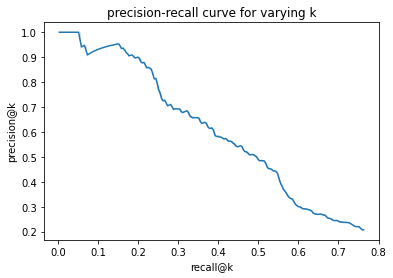

In [63]:
precision_at_k = {}
recall_at_k = {}

for user in users:
    precision_at_k[user] = []
    recall_at_k[user] = []
    for k in range(1, 1000):
        precision = df["label"][:k].sum() / k
        recall = df["label"][:k].sum() / df["label"].sum()
        precision_at_k[user].append(precision)
        recall_at_k[user].append(recall)

# plot the precision-recall curve.
ax = sns.lineplot(recall_at_k[users[0]], precision_at_k[users[0]])
ax.set_title("precision-recall curve for varying k")
ax.set_xlabel("recall@k")
ax.set_ylabel("precision@k")

Achieving a high precision@k means a large proportion of top-k recommended items are relevant to the user. Recall@k shows what proportion of all relevant items appeared in the top-k recommendations.

**Mean Average Precision (MAP)**

Precision@k is a good metric for understanding how many relevant recommendations we might make at each top-k. However, we would prefer relevant items to be recommended first when possible and should encode that into our evaluation metric. **Average Precision (AP)** is a running average of precision@k, rewarding recommendations where the revelant items are seen earlier rather than later. When the averaged across all users for some k, the AP metric is called MAP.

MAP@50: 0.9550134073089636


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'MAP')

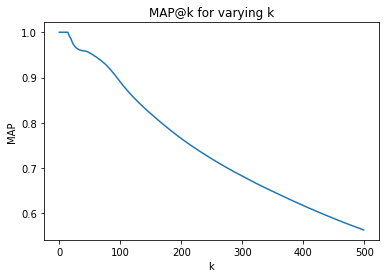

In [64]:
def calculate_ap(precision):
    ap = [precision[0]]
    for p in precision[1:]:
        ap.append(ap[-1] + p)
    ap = [x / (n + 1) for x, n in zip(ap, range(len(ap)))]
    return ap

ap_at_k = {user: calculate_ap(pk)
           for user, pk in precision_at_k.items()}

num_k = 500
map_at_k = [sum([ap_at_k[user][k] for user in users]) / len(users)
            for k in range(num_k)]
print("MAP@50: {}".format(map_at_k[49]))

# plot average precision.
ax = sns.lineplot(range(num_k), map_at_k)
ax.set_title("MAP@k for varying k")
ax.set_xlabel("k")
ax.set_ylabel("MAP")

## **Cleaning up**

To clean up all GCP resources used in this project, you can [delete the GCP
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

**Delete BigQuery datasets**

In order to delete BigQuery tables, make sure the service account linked to this notebook has a role with the bigquery.tables.delete permission such as Big Query Data Owner. The following command displays the current service account.

IAM permissions can be adjusted [here](https://console.cloud.google.com/navigation-error;errorUrl=%2Fiam-admin%2Fiam%3Fproject%3Dprj-automl-notebook&folder%3D&organizationId%3D/permissions).

In [ ]:
# Delete model resource.
tables_client.delete_model(model_name=model_name)

# Delete dataset resource.
tables_client.delete_dataset(dataset_name=dataset_name)

# Delete the prediction dataset.
dataset_id = str(output_uri[5:].replace(":", "."))
bq_client.delete_dataset(dataset_id, delete_contents=True, not_found_ok=True)

# Delete the training dataset.
dataset_id = "{0}.{1}".format(PROJECT_ID, BQ_DATASET_NAME)
bq_client.delete_dataset(dataset_id, delete_contents=True, not_found_ok=True)

# If training model is still running, cancel it.
automl_client.transport._operations_client.cancel_operation(operation_id)